In [2]:
!pip install meteostat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import warnings
# warnings.filterwarnings('ignore')

In [4]:
# Set time period
#For Daily
# start = datetime(2018, 1, 1)
# end = datetime(2018, 12, 31)

##For Hourly##
start = datetime(2020, 1, 1)
end = datetime(2020, 12, 31, 23, 59)


# Get Hourly data for 2020 on Hartsfield-Jackson Atlanta (Meteostat ID 72219)
data = Hourly('72219', start, end)
data = data.fetch()
data.info()
data.isna().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8784 non-null   float64
 1   dwpt    8784 non-null   float64
 2   rhum    8784 non-null   float64
 3   prcp    8209 non-null   float64
 4   snow    0 non-null      float64
 5   wdir    8784 non-null   float64
 6   wspd    8784 non-null   float64
 7   wpgt    0 non-null      float64
 8   pres    8784 non-null   float64
 9   tsun    0 non-null      float64
 10  coco    8784 non-null   float64
dtypes: float64(11)
memory usage: 823.5 KB


temp       0
dwpt       0
rhum       0
prcp     575
snow    8784
wdir       0
wspd       0
wpgt    8784
pres       0
tsun    8784
coco       0
dtype: int64

In [5]:
weather = data
#Dropping Null and Nominal Columns 
weather_drp1 = weather.drop(columns = ['snow','tsun','wpgt','coco'])
weather_drp1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8784 entries, 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    8784 non-null   float64
 1   dwpt    8784 non-null   float64
 2   rhum    8784 non-null   float64
 3   prcp    8209 non-null   float64
 4   wdir    8784 non-null   float64
 5   wspd    8784 non-null   float64
 6   pres    8784 non-null   float64
dtypes: float64(7)
memory usage: 549.0 KB


In [6]:
## Checking for Null Value and Replacing them with MEAN
print(weather_drp1.apply(pd.isnull).sum()/weather_drp1.shape[0])
weather_drp1['prcp'].fillna(weather_drp1['prcp'].mean(),inplace = True)
print(weather_drp1.isnull().sum())


temp    0.00000
dwpt    0.00000
rhum    0.00000
prcp    0.06546
wdir    0.00000
wspd    0.00000
pres    0.00000
dtype: float64
temp    0
dwpt    0
rhum    0
prcp    0
wdir    0
wspd    0
pres    0
dtype: int64


In [7]:
## Percentage of 0
counts = []
for i in range(0,7):
  count = (weather_drp1.iloc[:,i] == 0).sum()/len(weather_drp1)
  counts.append(count)
counts

[0.0034153005464480873,
 0.006944444444444444,
 0.0,
 0.8602003642987249,
 0.07832422586520947,
 0.07832422586520947,
 0.0]

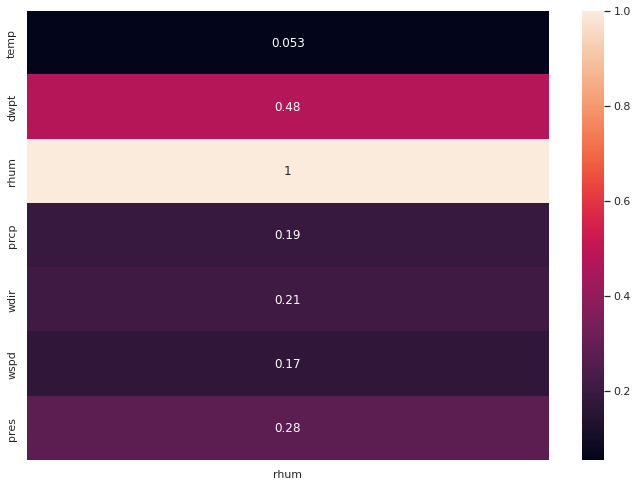

In [8]:
#correlation for the numerical data with respect to "rhum"

corr = pd.DataFrame(weather_drp1.corr()[['rhum']].abs())
#visual representation
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(corr, xticklabels=True, yticklabels=True, annot=True)
# weather_drp1

In [9]:
## A ssigning "rhum" as target variable ##
weather_y=weather_drp1.iloc[:,2]
weather_x=weather_drp1.drop(columns = 'rhum')

In [10]:
## Train and Test Data ##
x_train,x_test,y_train,y_test=train_test_split(weather_x,weather_y,test_size=0.2,random_state=4)

## Importing Necessary Models and Error Models ## 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import warnings


In [11]:
## PipeLine ##
models_to_test = {
                  'decision tree': DecisionTreeRegressor(random_state=42),
                  'random forest': RandomForestRegressor(n_estimators=100, random_state=42),
                  'ML Regressor' : MLPRegressor(random_state=1, max_iter=400)
                  }
def predict_and_return_error(y_predict, y_test):
    MAE = mean_absolute_error(y_test, y_predict)
    lin_mse = mean_squared_error(y_test, y_predict)
    lin_rmse = np.sqrt(lin_mse)
    r2 = r2_score(y_test, y_predict)
    warnings.simplefilter("ignore")

    return MAE, lin_mse, lin_rmse,r2




In [12]:
## Train and Predic ##
models_to_test['decision tree'].fit(x_train, y_train)
models_to_test['random forest'].fit(x_train, y_train)
models_to_test['ML Regressor'].fit(x_train, y_train)


y_predictrd = models_to_test['decision tree'].predict(x_train)
y_predictrr = models_to_test['random forest'].predict(x_train)
y_predictrml = models_to_test['ML Regressor'].predict(x_train)

y_predictd = models_to_test['decision tree'].predict(x_test)
y_predictr = models_to_test['random forest'].predict(x_test)
y_predictml = models_to_test['ML Regressor'].predict(x_test)


yr = pd.DataFrame([y_predictrd,y_predictrr,y_predictrml ])
y = pd.DataFrame([y_predictd,y_predictr,y_predictml ])

In [14]:
## Accuracy Check ##
error = [] # test data error
er = []
trer = [] # train data error
trerror =[]

for i in range (0,len(y)):
  error = predict_and_return_error(y.iloc[i,:], y_test)
  er.append(error)
# print(er)

for i in range (0,len(y)):
  trerror = predict_and_return_error(yr.iloc[i,:], y_train)
  trer.append(trerror)
# print(trer)

  

name = ['Decision Tree','Random Forest', 'ML']

er = pd.DataFrame(er)
er['Name'] = name
er = er.rename(columns={0: 'MAE', 1: 'MSE', 2: 'RMSE', 3: 'R^2'})

print(er)

        MAE       MSE      RMSE       R^2           Name
0  0.604439  3.323847  1.823142  0.989990  Decision Tree
1  0.502168  1.295760  1.138314  0.996098  Random Forest
2  2.260537  9.314630  3.051988  0.971949             ML


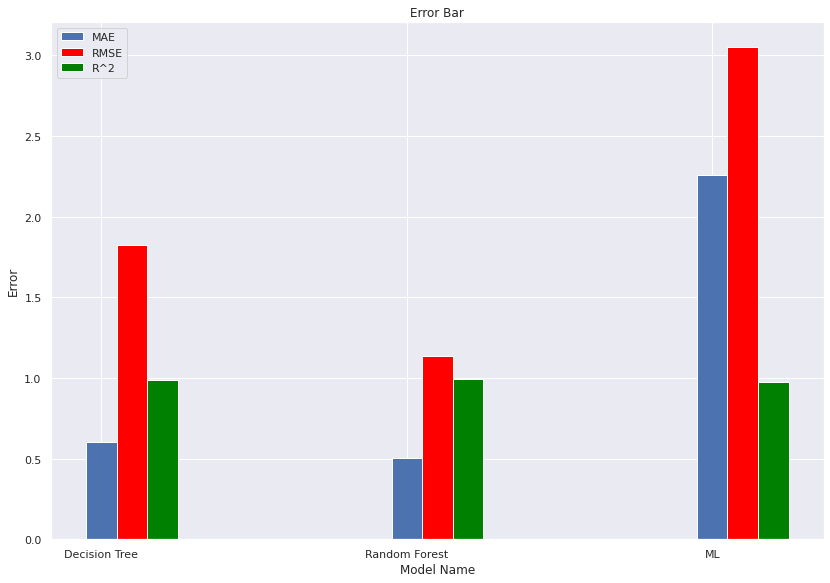

In [15]:
## Visualization of Accuracy ##
model_name = er.iloc[:,4]
#error = er.iloc[0:3,0:4]
x = np.arange(len(model_name))
width = .2
plt.bar(x, er.iloc[:,0], width/2,label = 'MAE')
plt.bar(x+ width/2, er.iloc[:,2], width/2, label = 'RMSE',color = 'red')
plt.bar(x+ width/2*2, er.iloc[:,3], width/2, label = 'R^2',color = 'green')


# plt.bar( x + width/2*2 , er.iloc[:,2], width/2,label = 'RMSE')


plt.xticks(x,model_name)
# plt.yticks(x,model_name)
plt.xlabel("Model Name")
plt.ylabel("Error")
plt.title("Error Bar")
plt.tight_layout()
plt.legend()
plt.show()
